This notebook extends the functionality of augment coordinates to triclinic cells. It builds upon the notebook [1](https://github.com/ayushsuhane/Benchmarks_Distance/blob/master/Notebooks/Augment_Guessbonds.ipynb), and [2](http://www.richardjgowers.com/2018/06/28/make_halos.html) which can be used to incorporate periodic boundary conditions using Cython. 

The structure of the notebook is arranged as follows:
* Definition of Augment Functions
* Definition of Helper functions
* Test case to check results of PKDTree in MDAnalysis and current version of augment coordinates
* Performance for orthonormal box
* Performance for triclinic cells

Lets start with the function definition for augmenting particles.

In [4]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [5]:
%%cython --annotate

cimport cython
import cython

cimport numpy as np
import numpy as np

from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def make_halo(float[:, ::1] coordinates, float[:,::1] box, float[:,::1] reciprocal, float r):
    """Calculate augmented coordinate set
    
    Parameters
    ----------
    coordinates : np.ndarray
      coordinates to augment
    box : np.ndarray
      size of box
    rm : np.ndarray
      reciprocal matrix
    r : float
      thickness of halo region to buffer by
      
    Returns
    -------
    augmented : np.ndarray
      coordinates of the new augmented coordinates
    indices : np.ndarray
      original indices of the augmented coordinates
    """
    cdef bint lo_x, hi_x, lo_y, hi_y, lo_z, hi_z
    cdef int i, j, p, N
    cdef float shiftX[3]
    cdef float shiftY[3]
    cdef float shiftZ[3]
    cdef float coord[3]
    cdef float end[3]
    cdef float other[3]
    
    cdef int dim
    dim = coordinates.shape[1]
    # room for adding triclinic support by using (3,) vectors
    for i in range(dim):
        shiftX[i] = box[0, i]
        shiftY[i] = box[1, i]
        shiftZ[i] = box[2, i]
        end[i] = box[0, i] + box[1, i] + box[2,i]
    N = coordinates.shape[0]
    p = 0  # output counter
    # allocate output arrays
    # could be more conservative with this
    # or use C++ vectors + push etc
    cdef float[:, :] output = np.zeros((N, 3), dtype=np.float32)
    cdef int[:] indices = np.zeros(N, dtype=np.int32)

    for i in range(0,N):
        for j in range(3):
            coord[j] = coordinates[i, j]
            other[j] = end[j] - coordinates[i,j]
        # identify the condition 
        lo_x = _dot(&coord[0], &reciprocal[0,0]) <= r
        hi_x = _dot(&other[0], &reciprocal[0,0]) <= r
        lo_y = _dot(&coord[0], &reciprocal[1,0]) <= r
        hi_y = _dot(&other[0], &reciprocal[1,0]) <= r
        lo_z = _dot(&coord[0], &reciprocal[2,0]) <= r
        hi_z = _dot(&other[0], &reciprocal[2,0]) <= r
        
        if lo_x:
            # if X, face piece
            for j in range(3):
                # add to output
                output[p, j] = coord[j] + shiftX[j]
            # keep record of which index this augmented position was created from
            indices[p] = i
            p += 1
           
            if lo_y:
                # if X&Y, edge piece
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] + shiftY[j]
                indices[p] = i
                p += 1
                
                
                if lo_z:
                    # if X&Y&Z, corner piece
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] + shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] + shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                    

            elif hi_y:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] - shiftY[j]
                indices[p] = i
                p += 1
                
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] - shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] - shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                
            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
               
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
                
        elif hi_x:
            for j in range(3):
                output[p, j] = coord[j] - shiftX[j]
            indices[p] = i
            p += 1
            
            
            if lo_y:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] + shiftY[j]
                indices[p] = i
                p += 1
                
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] + shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] + shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                

            elif hi_y:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] - shiftY[j]
                indices[p] = i
                p += 1
                
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] - shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] - shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                    
            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        if lo_y:
            for j in range(3):
                output[p, j] = coord[j] + shiftY[j]
            indices[p] = i
            p += 1
            
            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftY[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftY[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        elif hi_y:
            for j in range(3):
                output[p, j] = coord[j] - shiftY[j]
            indices[p] = i
            p += 1
            

            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftY[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftY[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        if lo_z:
            for j in range(3):
                output[p, j] = coord[j] + shiftZ[j]
            indices[p] = i
            p += 1
            
        elif hi_z:
            for j in range(3):
                output[p, j] = coord[j] - shiftZ[j]
            indices[p] = i
            p += 1
            
    return np.array(output[:p]), np.array(indices[:p])


@cython.boundscheck(False)
@cython.wraparound(False)
cdef float _dot(float  *a, float *b):
    """Return dot product of two sequences in range."""
    cdef ssize_t n
    cdef float sum1
    cdef ssize_t dim
    
    dim=3
    sum1 = 0.0
    for n in range(dim):
        sum1 += a[n] * b[n]
    return sum1


@cython.boundscheck(False)
@cython.wraparound(False)
def undo_augment(int[:] results, int[:] translation, int nreal):
    """Translate augmented indices back to originals
    
    Note: modifies results in place!
    
    Parameters
    ----------
    results : ndarray of ints
      indices of coordinates, including "augmented" indices
    translation : ndarray of ints
      original indices of augmented coordinates
    nreal : int
      number of real coordinates, ie values in results equal or larger than this
      need to be translated to their real counterpart
      
    Returns
    -------
    results : ndarray of ints
    """
    cdef int N
    
    N = results.shape[0]
    
    for i in range(N):
        if results[i] >= nreal:
            results[i] = translation[results[i] - nreal]
            
    return results

In [6]:
from MDAnalysis.lib.distances import triclinic_vectors
from MDAnalysis.lib.mdamath import norm
from scipy import spatial
def augment_kdtree(coords, cutoff, box):
    """
    box of type [A,B,C,a1,a2,a3]
    """
    box = triclinic_vectors(box)
    # Define reciprocal matrix
    rm = np.zeros(9, dtype=np.float32).reshape(3, 3)
    rm[0] = np.cross(box[1], box[2])
    rm[1] = np.cross(box[2], box[0])
    rm[2] = np.cross(box[0], box[1])
    for i in range(3):
        rm[i] /= norm(rm[i])  # normalize
    aug, idx = make_halo(coords, box, rm, cutoff)
    aug_coord = np.concatenate([coords, aug])
    kdtree = spatial.cKDTree(aug_coord)
    pairs = np.array(list(kdtree.query_pairs(cutoff)), dtype=np.int32)
    if len(pairs) > 1:
        undo_augment(pairs[:, 0], idx, len(coords))
        undo_augment(pairs[:, 1], idx, len(coords))
        pairs = np.unique(np.sort(pairs), axis=0)
    return pairs

In [7]:
import MDAnalysis.lib.distances as distances
def pkdtree(coords, cutoff, box):
    pairs, dist = distances.capped_distance(coords, coords, max_cutoff=cutoff, min_cutoff=1e-7, box=box, method='pkdtree')
    if len(pairs) > 1:
        pairs = pairs[np.where(pairs[:, 0] < pairs[:, 1])[0]]
    return np.asarray(pairs)

Define the helper functions for setup, testing and benchmarks

In [8]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [9]:
box = np.array([100., 100., 100., 90., 90., 90.], dtype=np.float32)
cutoff = 4.
npoints = 1000
coords = get_coords(box, npoints)

First check for all the pairs within a distance of 4 units in a orthogonal box.

In [10]:
pairs_pkd = pkdtree(coords, cutoff, box)

In [11]:
pairs_augment = augment_kdtree(coords, cutoff, box)

In [12]:
np.testing.assert_array_equal(pairs_pkd, pairs_augment)

Lets check for an arbitrary triclinic system

In [13]:
box = np.array([100., 100., 100., 80., 70., 90.], dtype=np.float32)
cutoff = 4.
npoints = 1000
coords = get_coords(box, npoints)

In [14]:
pairs_pkd = pkdtree(coords, cutoff, box)

In [15]:
pairs_augment = augment_kdtree(coords, cutoff, box)

In [16]:
np.testing.assert_array_equal(pairs_pkd, pairs_augment)

Check the performance with increase in number of points. Variation in performance with different cutoff radius is already been done in this [notebook](https://github.com/ayushsuhane/Benchmarks_Distance/blob/master/Notebooks/Augment_Guessbonds.ipynb). The objective here is to check whether there is a significant drop in performance due to inclusion of triclinic system.

In [17]:
from tqdm import tqdm_notebook
from collections import defaultdict

First lets check the performance of orthogonal systems

In [18]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = np.logspace(2, 5, num=10, dtype= np.int)

In [20]:
result_guess = defaultdict(list)
for N in tqdm_notebook(np.unique(NPOINTS)):
    coords = get_coords(BOX, N)
    
    #Testing
    np.testing.assert_array_equal(pkdtree(coords, CUTOFF, BOX), augment_kdtree(coords, CUTOFF, BOX))
    
    #Timing
    res = %timeit -q -o pkdtree(coords, CUTOFF, BOX)
    result_guess['pkd'].append(res.average)
    
    res = %timeit -q -o augment_kdtree(coords, CUTOFF, BOX)
    result_guess['p_augment'].append(res.average)
    
    result_guess['N'].append(N)
    

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

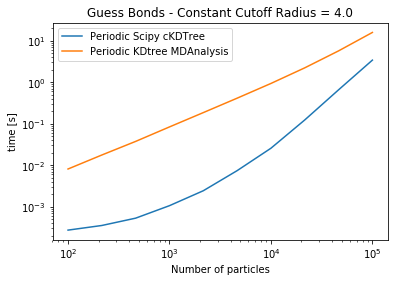

In [22]:
fig, axes = plt.subplots()

axes.plot(result_guess['N'], result_guess['p_augment'], label="Periodic Scipy cKDTree")
axes.plot(result_guess['N'], result_guess['pkd'], label="Periodic KDtree MDAnalysis")
axes.set(xlabel='Number of particles', ylabel='time [s]', xscale='log', yscale='log', title='Guess Bonds - Constant Cutoff Radius = {}'.format(CUTOFF))
axes.legend()

Similarly check for triclinic System

In [23]:
BOX = np.array([100.,100.,100.,70.,80.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = np.logspace(2, 5, num=10, dtype= np.int)

In [24]:
result_guess = defaultdict(list)
for N in tqdm_notebook(np.unique(NPOINTS)):
    coords = get_coords(BOX, N)
    
    #Testing
    np.testing.assert_array_equal(pkdtree(coords, CUTOFF, BOX), augment_kdtree(coords, CUTOFF, BOX))
    
    #Timing
    res = %timeit -q -o pkdtree(coords, CUTOFF, BOX)
    result_guess['pkd'].append(res.average)
    
    res = %timeit -q -o augment_kdtree(coords, CUTOFF, BOX)
    result_guess['p_augment'].append(res.average)
    
    result_guess['N'].append(N)
    

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

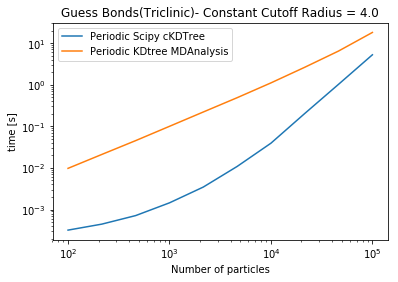

In [26]:
fig, axes = plt.subplots()

axes.plot(result_guess['N'], result_guess['p_augment'], label="Periodic Scipy cKDTree")
axes.plot(result_guess['N'], result_guess['pkd'], label="Periodic KDtree MDAnalysis")
axes.set(xlabel='Number of particles', ylabel='time [s]', xscale='log', yscale='log', title='Guess Bonds(Triclinic)- Constant Cutoff Radius = {}'.format(CUTOFF))
axes.legend()